# Feature visualization on DCGAN and WGAN trained on the MNIST dataset

## Imports for feature visualization

### Basics

In [1]:
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt 
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# For local imports (from "scripts")
import os, sys
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

### Objective

The `Objective` class lets us define what we aim to maximize. This can point to a neuron, a channel or a layer. It will be fed to the *activation maximizer* for the maximizing process.

The `layer_out` global variable is used to extract the state of the objective from inside the model during the training process.

In [14]:
from scripts.visualization.optimization_tools import Objective

layer_out = None

LAYER_OBJ = 1
CHANNEL_OBJ = 2
NEURON_OBJ = 3

### Activation maximizer

The `ActivationMaximizer` class provides the `optimize` function that trains the model to maximize the *objective* we have defined. Ths output of the maximization process is then the optimal model input for activating the *objective*.

In [15]:
from scripts.visualization.optimization_tools import GANActivationMaximizer

### Plotting

In [16]:
def plotObjectiveMaximization(model, objective, **kwargs):
    maximizer = GANActivationMaximizer(model, (1, 28, 28))

    transforms = [
        v2.RandomAffine(0, translate=(0.05, 0.05)),
        v2.RandomAffine(0, scale=(0.9, 1/0.9)),
        v2.RandomRotation(interpolation=v2.InterpolationMode.BILINEAR, degrees=3)
    ]

    start, result = maximizer.optimize(objective, transforms, **kwargs)
    result = result.detach().cpu()

    if objective.type == NEURON_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Neuron objective: {objective.neuron_index[1:]}")

        axs[0].imshow(result[0,:,:], cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().cpu()[objective.neuron_index[:2]], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == CHANNEL_OBJ:
        fig, axs = plt.subplots(1, 2)

        fig.suptitle(f"Channel objective: {objective.channel_index}")

        axs[0].imshow(result[0,:,:], cmap="inferno")
        axs[0].set_title("Optimized input")
        axs[1].imshow(layer_out.detach().cpu()[0, objective.channel_index], cmap="inferno")
        axs[1].set_title("Channel")

    elif objective.type == LAYER_OBJ:
        fig, ax = plt.subplots(1, 1)

        fig.suptitle(f"Layer objective")

        ax.imshow(result[0,:,:], cmap="inferno")
        ax.set_title("Optimized input")

    plt.tight_layout()
    plt.show()

## GANs

We will apply this to the GAN structure we have trained using the usual training process (DCGAN) and Wasserstein metrics (WGAN). The Generator and Discriminator structures are the same for both models.

```python
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=1, bias=False)
    (10): Sigmoid()
  )
)
```

In [ ]:
from scripts.GANs.utils.gan_struct import Discriminator

### DCGAN

In [3]:
# The pre-trained model
discriminator = torch.load("../models/DCGAN/mnist-gan-discriminator.pt", map_location=torch.device(device))

The first *objective* we will maximize is the channel 34 of the second `Conv2d` layer (layer 4). After 3000 iterations, we can see the optimized input and how the *objective* is activated.

100%|██████████| 3000/3000 [00:13<00:00, 219.14it/s]


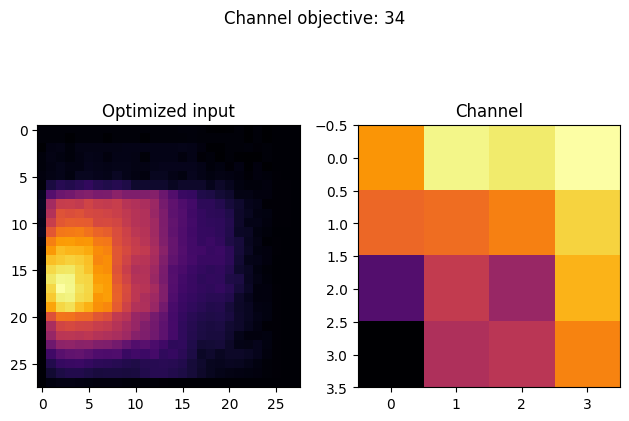

In [18]:
objective = Objective(CHANNEL_OBJ, discriminator.main[4], channel_index=34)
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3, device=device)

The second *objective* we will maximize is the first neuron of the same layer. After 3000 iterations, we can see the optimized input and how the *objective* is activated.

100%|██████████| 3000/3000 [00:13<00:00, 224.37it/s]


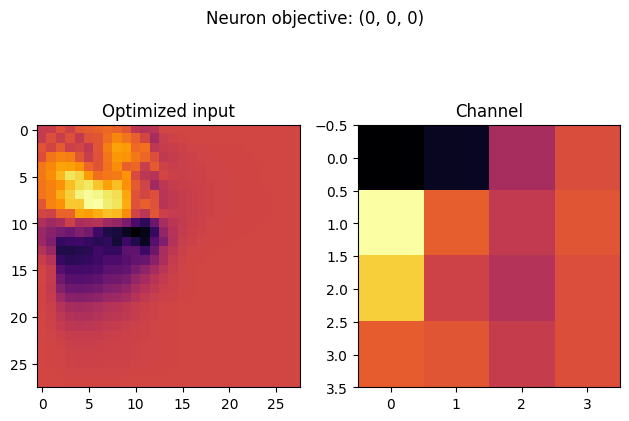

In [19]:
objective = Objective(NEURON_OBJ, discriminator.main[4], neuron_index=(0, 0, 0, 0))
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3, device=device)

### WGAN

We will now perform the same feature visualization but on the WGAN, whose training process differs from the DCGAN.

In [20]:
# The pre-trained model
discriminator = torch.load("../models/WGAN/mnist-wgan-discriminator.pt", map_location=torch.device(device))

The maximization *objectives* will be the same as before, so we start with channel 34 of the second `Conv2d`layer.

100%|██████████| 3000/3000 [00:14<00:00, 206.51it/s]


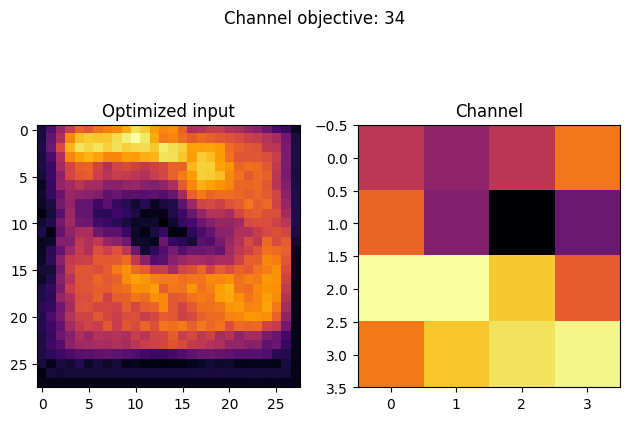

In [21]:
objective = Objective(CHANNEL_OBJ, discriminator.main[4], channel_index=34)
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3, device=device)

And then the first neuron of the same layer.

100%|██████████| 3000/3000 [00:14<00:00, 200.35it/s]


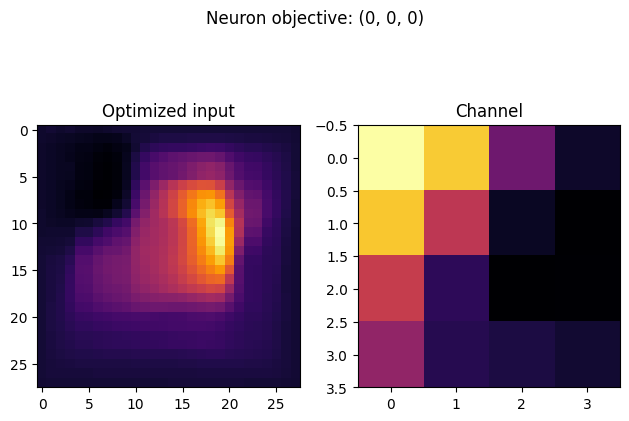

In [22]:
objective = Objective(NEURON_OBJ, discriminator.main[4], neuron_index=(0, 0, 0, 0))
plotObjectiveMaximization(discriminator, objective, iterations=3000, eta=1e-3, device=device)

### Observations

The results are completely different from one model to the other. This might be due to the different training processes, but also more simply because of the random initialisation of weights.